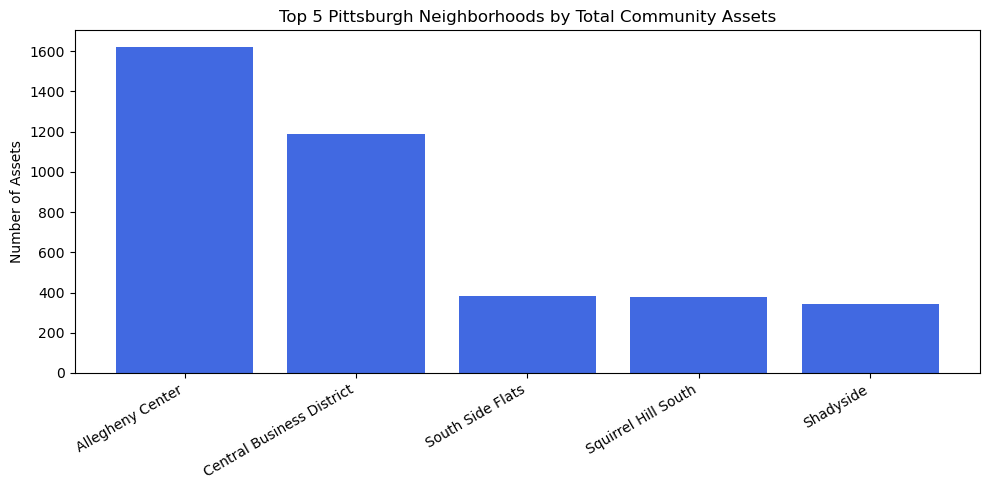

🏆 The best Pittsburgh neighborhood for community services is Allegheny Center with 1623 total assets.


In [4]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# --- Load Data ---
assets_url = "https://data.wprdc.org/datastore/dump/5c7825d2-6814-40c7-aefe-3d0f3d6f22e7"
assets = pd.read_csv(assets_url, low_memory=False)

neighborhoods_url = "https://data.wprdc.org/dataset/e672f13d-71c4-4a66-8f38-710e75ed80a4/resource/4af8e160-57e9-4ebf-a501-76ca1b42fc99/download/pittsburghpaneighborhoods-.geojson"
neighborhoods = gpd.read_file(neighborhoods_url)

# --- Clean & filter assets ---
assets = assets.dropna(subset=["latitude", "longitude"])
assets = assets[assets["city"].str.contains("Pittsburgh", case=False, na=False)]

assets_gdf = gpd.GeoDataFrame(
    assets,
    geometry=gpd.points_from_xy(assets.longitude, assets.latitude),
    crs="EPSG:4326"
)

# --- Spatial join ---
joined = gpd.sjoin(assets_gdf, neighborhoods, how="inner", predicate="within")

# --- Determine neighborhood column ---
hood_col = "hood" if "hood" in joined.columns else "name"

# --- Count assets per neighborhood ---
possible_cols = ["type", "asset_type", "Type", "category"]
asset_col = next((c for c in possible_cols if c in joined.columns), None)

if asset_col:
    neigh_counts = joined.groupby(hood_col)[asset_col].count().reset_index(name="Total Assets")
else:
    neigh_counts = joined.groupby(hood_col).size().reset_index(name="Total Assets")

# --- Top 5 neighborhoods ---
top5 = neigh_counts.sort_values("Total Assets", ascending=False).head(5)

# --- Bar chart ---
plt.figure(figsize=(10,5))
plt.bar(top5[hood_col], top5["Total Assets"], color="royalblue")
plt.title("Top 5 Pittsburgh Neighborhoods by Total Community Assets")
plt.ylabel("Number of Assets")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

# --- Print summary ---
best_neigh = top5.iloc[0][hood_col]
count = top5.iloc[0]["Total Assets"]
print(f"🏆 The best Pittsburgh neighborhood for community services is {best_neigh} "
      f"with {count} total assets.")